# 0. Imports

## 0.0. Imports

In [42]:
import re
import warnings

import numpy   as np
import pandas  as pd
import seaborn as sns

import umap.umap_ as umap

from matplotlib            import pyplot as plt
from IPython.display       import HTML
from yellowbrick.cluster   import KElbowVisualizer
from yellowbrick.cluster   import SilhouetteVisualizer

from sklearn               import cluster as c
from sklearn               import metrics as m
from plotly                import express as px
from matplotlib            import pyplot  as plt
from sklearn               import preprocessing as pp

## 0.1. Helper Functions 

In [52]:
warnings.filterwarnings("ignore")

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [14, 7]
    plt.rcParams['font.size'] = 24
    
    sns.set
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Load Dataset

In [3]:
# load data
df_raw = pd.read_csv('C:/Users/joaoh/repos/Insiders-Clustering/data/Ecommerce.csv', encoding='unicode_escape')

# drop extra column
df_raw = df_raw.drop('Unnamed: 8', axis=1)

# 1. Data Description

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Columns: 8


## 1.3.  Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [9]:
# remove NA
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}%'.format(100*(1-(df1.shape[0]/df_raw.shape[0]))))

Removed data: 24.93%


In [10]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6. Change Types

In [11]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)

In [12]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 1.7. Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [14]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988


#### 1.7.1.1. Numerical Attributes - Investigating

1. Negative Quantity (Refund?)
2. Unit Price equals Zero (Promo?)

### 1.7.2 Categorical Attributes

In [15]:
cat_attributes

,invoice_no,stock_code,description,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,17850,United Kingdom
...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,12680,France


#### Invoice Number

In [16]:
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

print('Total Number of Invoices: {}'.format(len(df_letter_invoices)))
print('Total Number of Negative Quantity: {}'. format(len(df_letter_invoices)))

Total Number of Invoices: 8905
Total Number of Negative Quantity: 8905


#### Stock Code

In [17]:
# check stock_code only characters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

# Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

#### Description

In [18]:
# ====== Nothing ======

#### Country

In [19]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [20]:
df1['country'].value_counts(normalize=True)

United Kingdom          0.889509
Germany                 0.023339
France                  0.020871
EIRE                    0.018398
Spain                   0.006226
Netherlands             0.005828
Belgium                 0.005086
Switzerland             0.004614
Portugal                0.003638
Australia               0.003095
Norway                  0.002669
Italy                   0.001974
Channel Islands         0.001863
Finland                 0.001708
Cyprus                  0.001529
Sweden                  0.001136
Austria                 0.000986
Denmark                 0.000956
Japan                   0.000880
Poland                  0.000838
USA                     0.000715
Israel                  0.000615
Unspecified             0.000600
Singapore               0.000563
Iceland                 0.000447
Canada                  0.000371
Greece                  0.000359
Malta                   0.000312
United Arab Emirates    0.000167
European Community      0.000150
RSA       

# 2.0. Features Filtering

In [21]:
df2 = df1.copy()

In [22]:
# unit price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# stock code != [POST, D, M, DOT, CRUK]
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'DOT', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] > 0, :]

# 3. Feature Engineering

In [23]:
df3 = df2.copy()

## 3.1. Feature Creation

In [24]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

In [25]:
# Gross Revenue
df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

In [26]:
# Recency - Last Day Purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()       
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

In [27]:
# Frequency
df_freq = df2_purchases.loc[:,['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

In [28]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

# 4. Exploratory Data Analysis

In [29]:
df4 = df_ref.dropna()

# 5. Data Preparation

In [30]:
df5 = df4.copy()

In [31]:
# Standard Scaler
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])

# 6. Feature Selection

In [32]:
df6 = df5.copy()

# 7. Hyperparameter Fine-Tuning

In [33]:
df7 = df6.drop(columns=['customer_id'])

In [34]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1. Within-Cluster Sum of Square (WSS)

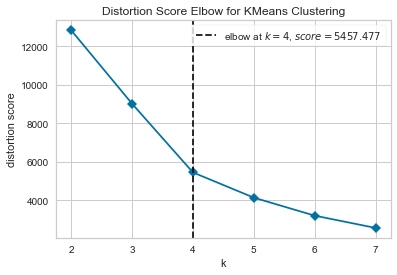

In [35]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(df7)
kmeans.show();

## 7.2. Silhouette Score

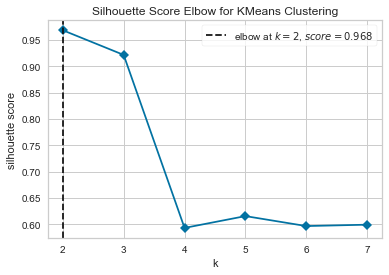

In [36]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(df7);
kmeans.show();

### 7.2.1. Silhouette Analysis

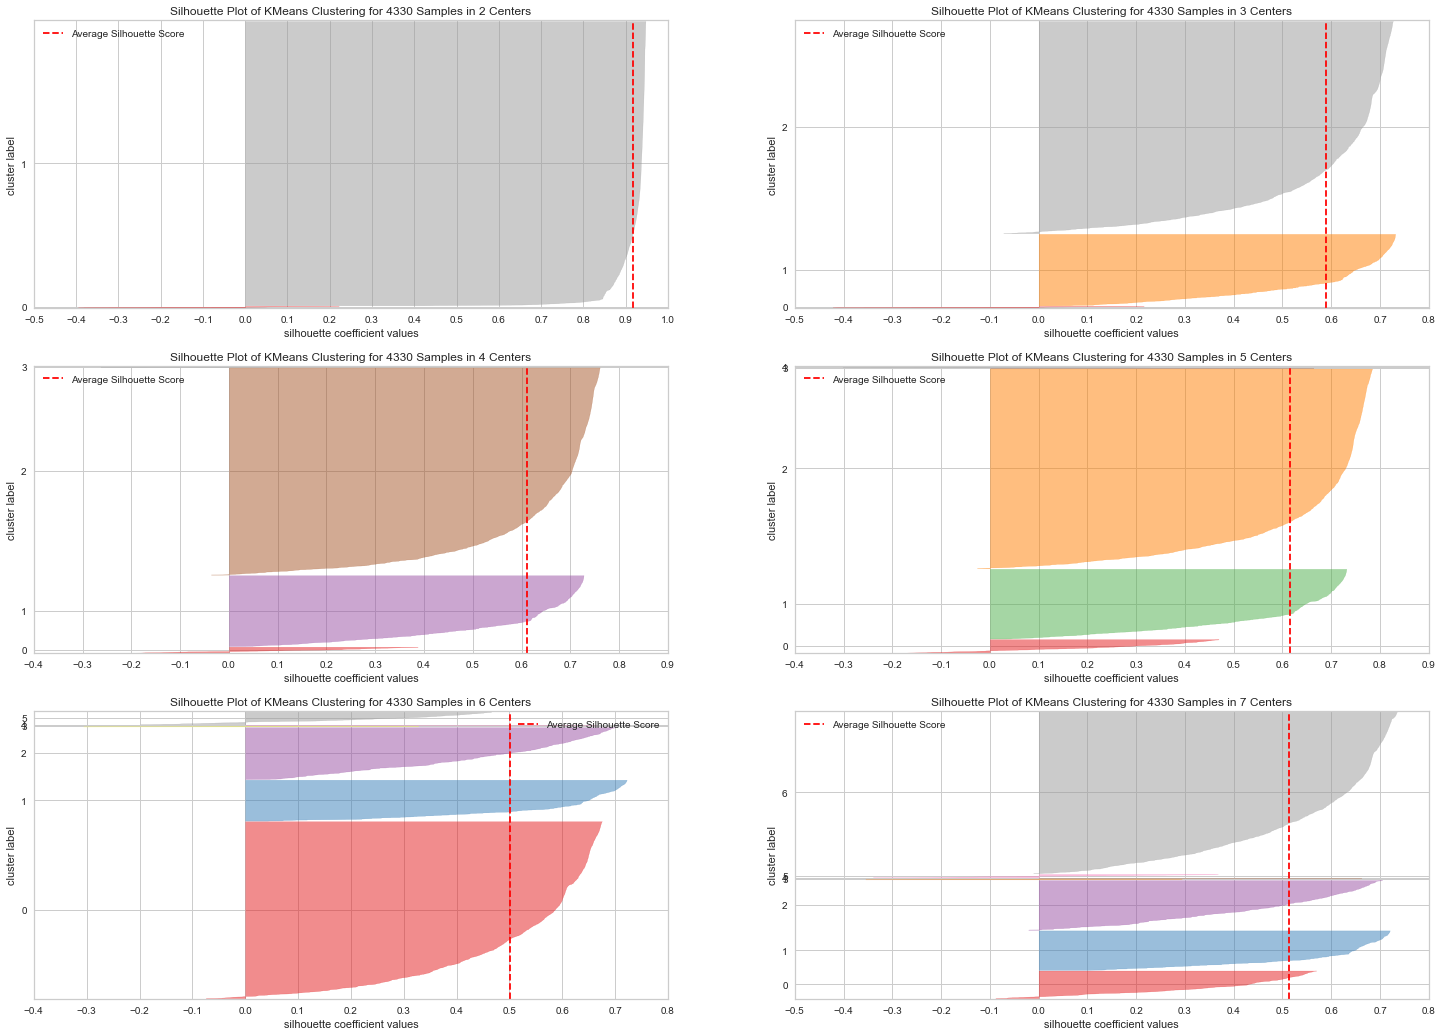

In [37]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df7);
    visualizer.finalize()

# 8. Model Training

In [38]:
df8 = df7.copy()

## 8.1. K-Means

In [39]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300)

# model training
kmeans.fit(df8)

# clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [43]:
## WSS ( Within-Cluster Sum of Square)
print('WSS Value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('Silhouette Score: {}'.format(m.silhouette_score(df8, labels, metric='euclidean')))

WSS Value: 9404.957923270293
Silhouette Score: 0.5895242294229587


# 9. Cluster Analysis

In [44]:
df9 = df6.copy()
df9['cluster'] = labels

In [45]:
df9

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.377193,2.791512,3.889210,-0.033939,1
1,13047,0.135388,-0.361004,0.620928,-0.033427,0
2,12583,0.524404,-0.899726,1.405316,-0.026622,0
3,13748,-0.120499,0.028072,0.098003,-0.023244,0
4,15100,-0.128592,2.402435,-0.163459,0.152443,1
...,...,...,...,...,...,...
4352,13436,-0.204665,-0.909702,-0.424922,-0.035126,0
4353,15520,-0.188242,-0.909702,-0.424922,-0.033305,0
4354,13298,-0.186394,-0.909702,-0.424922,0.076216,0
4355,14569,-0.201248,-0.909702,-0.424922,-0.033396,0


## 9.1. Visualization Inspection

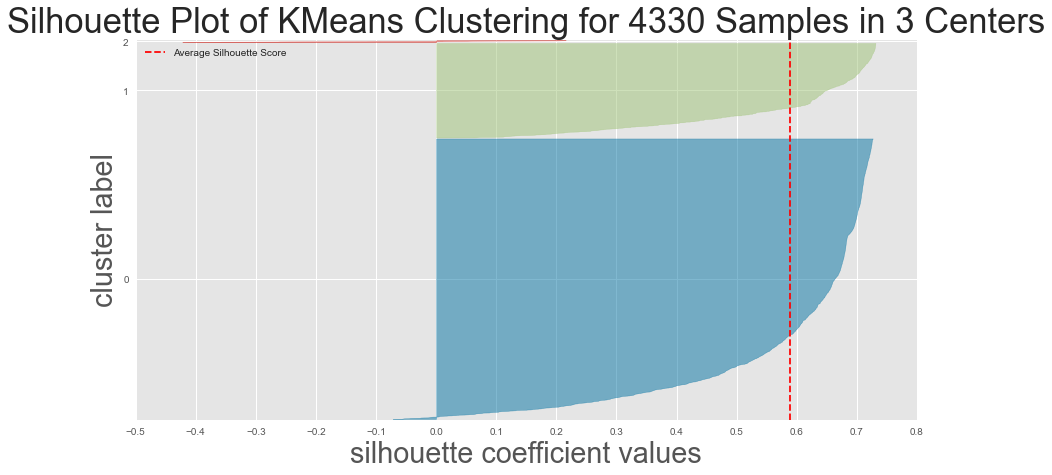

In [53]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df8)
visualizer.finalize()

## 9.2. 2D Plot

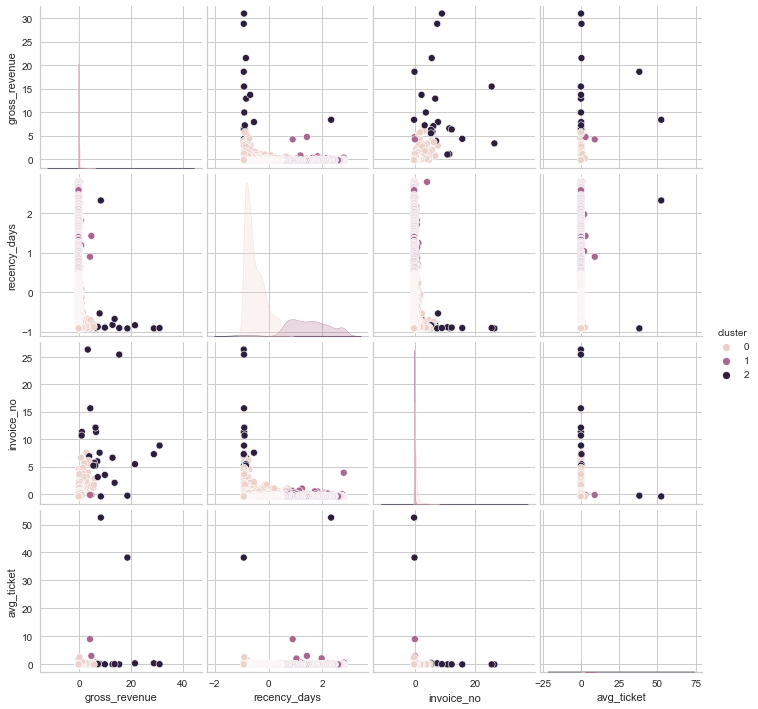

In [47]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3. UMAP - t-SNE

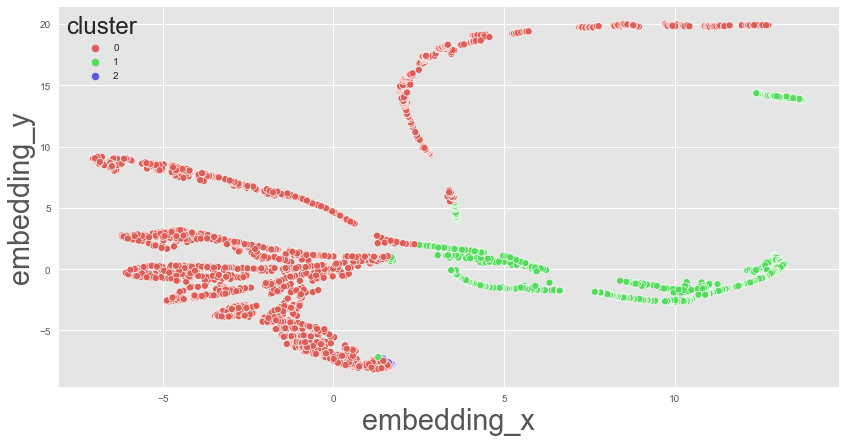

In [54]:
reducer = umap.UMAP(n_neighbors=50, random_state=42)
embedding = reducer.fit_transform(df8)

# embedding
df9['embedding_x'] = embedding[:, 0]
df9['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', 
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df9['cluster'].unique())),
                data=df9);

## 9.2. Cluster Profile

In [55]:
# Number of Customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Average Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Average Recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Average Invoice Number
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Average Ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,3222,74.411085,-0.015104,-0.513786,0.060431,-0.025681
1,1,1086,25.080831,-0.164555,1.538960,-0.350287,-0.008679
2,2,22,0.508083,10.335114,-0.722419,8.441036,4.189468


### Cluster 01: Insiders Candidate
    - Number of Customers: 6 (0.14%)
    - Avg Recency: 7 days.
    - Avg Purchases: 89 purchases.
    - Avg Revenue: $182,182.98 dollars.

### Cluster 02:
    - Number of Customers: 14 (0.13%)
    - Avg Recency: 13 days.
    - Avg Purchases: 53 purchases.
    - Avg Revenue: $40,543.51 dollars.
    
### Cluster 03: 
    - Number of Customers: 4335 (99,15%)
    - Avg Recency: 92 days.
    - Avg Purchases: 4 purchases.
    - Avg Revenue: $1,372.57 dollars.

# 10. Deploy To Production